<a href="https://colab.research.google.com/github/JacquelineFlanigan/OtoscopyPredictions/blob/main/Otoscopy_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Machine Learning to Identify Ear Infections
Have your ever had pain that seemed to come from inside your ears? Chances are that you have and that your family doctor/audiologist has taken a quick peek inside to see what might be causing your discomfort. They may have even taken an otoscopy, which is a fancy term that just means that they've used a special instrument to take a picture of what your inner ear looks like. 

One of the main causes of affliction in the inner ears is called acute otitis media, otherwise known as an infecion of the middle ear. Usually this is more common in children six to twenty-four months, but can occur in adults as well. What we plan to do here is create a convolutional neural network that will take in otoscopies that range from normal (no infection) to abnormal (has infection) and will be able to predict if someone has acute otitis media. We will use roughly around 654 pictures to help our model determine the diagnosis of the ears although it should be mentioned that this model should not be used in place of a doctor. 

Let's get into it by downloading the necessary libraries and files! 

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import csv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import plot_tree
from sklearn import tree
from six import StringIO
from skimage import io
from skimage.io import imread
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import os, shutil
from os.path import isfile, join
from pathlib import Path
import cv2
import glob
import argparse
import PIL
from PIL import Image

#!pip install tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import os
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#getting path and folder from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#double checking that the files are image files before moving on
import os
from os import listdir
from PIL import Image

dir_path = "/content/drive/MyDrive/Data"


for filename in listdir(dir_path):
    if filename.endswith('.png'):
        try:
            img = Image.open(data_path+"//"+filename) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename, e)
            #os.remove(dir_path+"//"+filename) (Maybe)


#Exploring Our Data and Getting Some Insights

Here we're going to take a little deeper look into our dataset to better understand what our model will be working with. The original dataset included nine total classes but we have narrowed it down to just those labeled as normal and those as acute otitis media (labeled initially as "aom"), which the later is now categorized as abnormal. We did this to better focus our model to a specific purpose and hopefully be able to better tune it to our needs.

We've split our now gathered data into three paths: a train, test and validation path. The train and test set do just as they infer with their labels for our model but with our validation set, it allows us the opportunity to improve the quality/quantity of the data. This happens by reducing the bias and variance of the model since if the validation accuracy is greater than the training accuracy, then there is a high chance of our model being overfitted to the data. 

We've also grayscaled our images in the dataset for a few different reasons. One is the acute otitis media diagnosis does not depend on the color of the eardrum, but rather the position and mobility of the eardrum. There is also the fact that each otoscopy image will range in hue due to the otoscope instrument itself; two otoscopes may take an image of the same ear but they may look different in color due to different bulbs in each of the instruments. And lastly, it is to simplify prediction for our model since it will be easier for the model to understand and evaluate. 

Lastly, we'll discuss the augmentation of our images. Here were used the Keras ImageDataGenerator to alter and increase the images in the train set to improve the performance of our model. Doing so allows our model to better generalize the data and helps prevent overfitting. 

In [4]:
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/Data/train'
test_path = '/content/drive/MyDrive/Data/test'
valid_path = '/content/drive/MyDrive/Data/validation'

#The batch refers to the number of training examples utilized in one iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 
img_height = 500
img_width = 500

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 217 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [7]:
#all_imgs = pd.DataFrame(train, test, valid)

print(type(train))

<class 'keras.preprocessing.image.DirectoryIterator'>


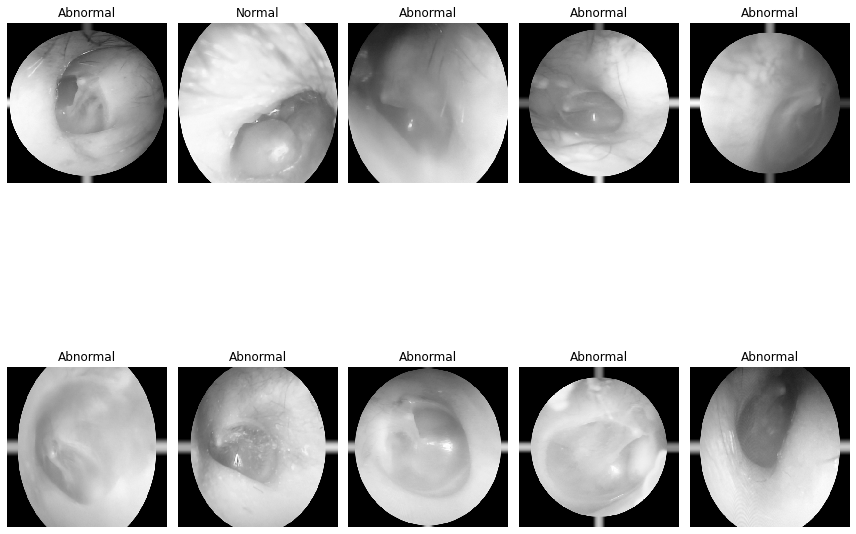

In [8]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'Normal', 1:'Abnormal'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

Above we can see some examples from our augmented data. Here, without the definition labels above the pictures, it is difficult for a person who isn't a physician/audiologist to identify which eardrums have acute otitis media. Now let's move on to our modeling process.

#Building Our First Model
We've finally arrived at the modeling process after taking a peek into our dataset. We'll be using a convolutional neural network, which will be able to essentially "read" our images through some essential steps. Some of the parameters we used here are relu and max pooling since together they add nonlinearity in addition to taking in the most prominent features of our dataset. After some necessary filtering and flattening of the layers, we can also optimize our model to have an adaptive learning rate and compare our predicted probabilities to our actual class outputs. While running our model, we can focus on the accuracy of it all and will be able to test just how well our model will run. 

In [9]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

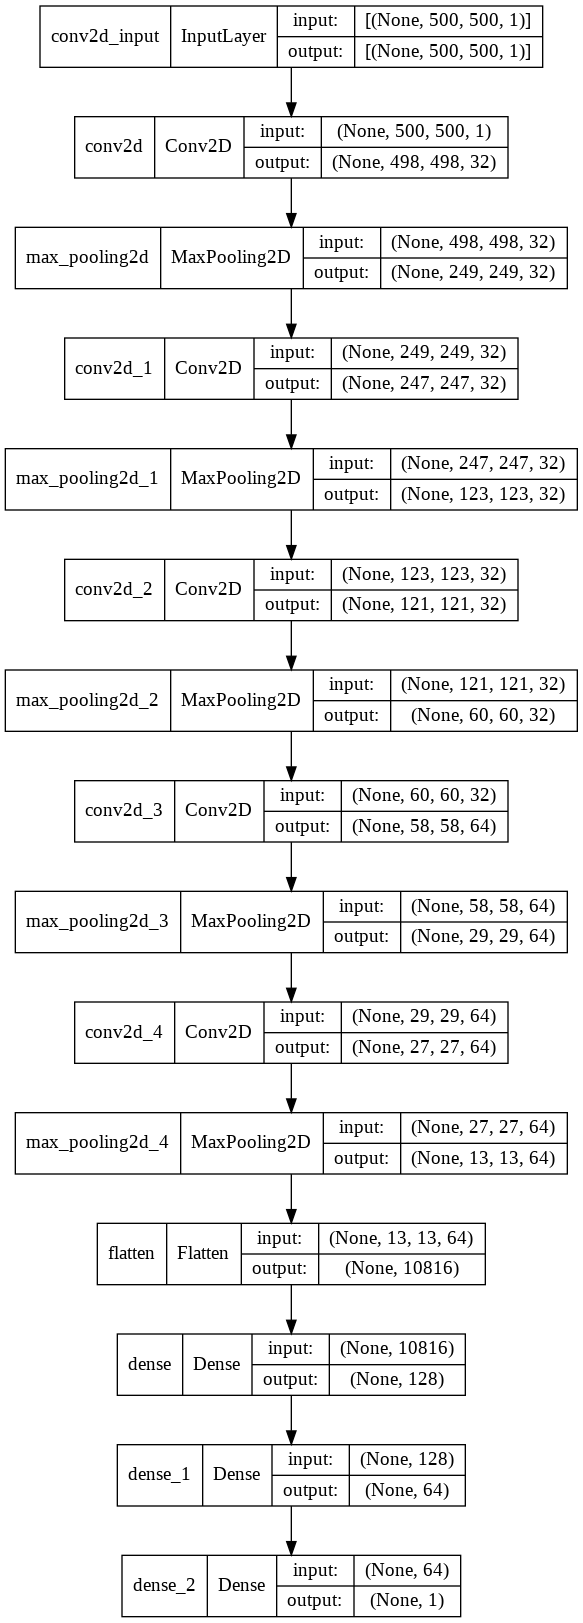

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

Above, we can visually see each step our model takes to get to our results. This is good to look at so that we can glimpse at what our model is actually doing at each stage and how it could affect our outcome. Next we'll introduce early stopping, which will stop the epochs (otherwise known as how many passes the dataset has gone forwards and backwards in its entirity) based on the conditions we've given it. This help to hopefully avoid overfitting our model to this specific dataset and be able to keep an eye on the errors that may occur. We've also made sure to have our model know when to stop going through iterations of the dataset if there isn't any progress being made, which will reduce the learning rate and improve the quality of the model over all. Additionally, we've also included balanced class weights so that our model can achieve a more accurate representation by tuning data distribution. This is important since we have more images for the normal category than abnormal and we don't want to skew the results based on this fact. The next step will be to acually fit our model and see how it does!



In [12]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [13]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 2.782051282051282, 1: 0.6095505617977528}


#First Model

In [14]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
14/14 [==============================] - 95s 6s/step - loss: 0.7014 - accuracy: 0.6636 - val_loss: 0.6396 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - 81s 6s/step - loss: 0.6999 - accuracy: 0.2719 - val_loss: 0.6753 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.8203
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
14/14 [==============================] - 82s 6s/step - loss: 0.6899 - accuracy: 0.8203 - val_loss: 0.6822 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 4/25
14/14 [==============================] - 78s 6s/step - loss: 0.6869 - accuracy: 0.8571 - val_loss: 0.6354 - val_accuracy: 0.8182 - lr: 3.0000e-04
Epoch 5/25
14/14 [==============================] - 78s 6s/step - loss: 0.6901 - accuracy: 0.8203 - val_loss: 0.5951 - val_accuracy: 0.8136 - lr: 3.0000e-04
Epoch 6/25
14/14 [==============================] - 83s 6s/step 

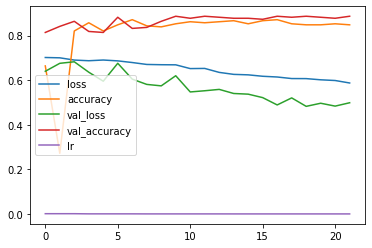

In [15]:
pd.DataFrame(cnn.history.history).plot()

From the information above we can see that the model stopped at the eighth epoch, meaning that when we run the model again, we should stop there since not much is learned from our data after that point. Also the graph indicates that accuracy after four epochs drops significantly, which indicates that perhaps less iterations of our model is better. The testing accurary below also shows a low percentage of around 41, so changes must be made to the initial model for better results. 

In [16]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :', test_accu[1]*100, '%')

14/14 [==============================] - 16s 1s/step - loss: 0.7760 - accuracy: 0.4747
The testing accuracy is : 47.46543765068054 %


#Rerunning Our First Model
Like stated above, now that we have seen what could potentially improve our model we need to reflect that in our code. We do so by changing the epochs to 8 and then testing to see if that works or not.

In [17]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn.fit(train,epochs=8, validation_data=valid, class_weight=cw, callbacks=callbacks_list)


Epoch 1/8
14/14 [==============================] - 84s 6s/step - loss: 0.6953 - accuracy: 0.7558 - val_loss: 0.6925 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 2/8
14/14 [==============================] - 78s 6s/step - loss: 0.6934 - accuracy: 0.8065 - val_loss: 0.6661 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 3/8
14/14 [==============================] - 77s 6s/step - loss: 0.6826 - accuracy: 0.8525 - val_loss: 0.6726 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 4/8
14/14 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.5853
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
14/14 [==============================] - 78s 6s/step - loss: 0.7079 - accuracy: 0.5853 - val_loss: 0.9851 - val_accuracy: 0.1864 - lr: 0.0010
Epoch 5/8
14/14 [==============================] - 77s 5s/step - loss: 0.7098 - accuracy: 0.1797 - val_loss: 0.7042 - val_accuracy: 0.2682 - lr: 3.0000e-04


In [18]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :', test_accu[1]*100, '%')

14/14 [==============================] - 16s 1s/step - loss: 0.7509 - accuracy: 0.2074
The testing accuracy is : 20.73732763528824 %


In [19]:
preds = cnn.predict(test,verbose=1)

14/14 [==============================] - 16s 1s/step


In [20]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

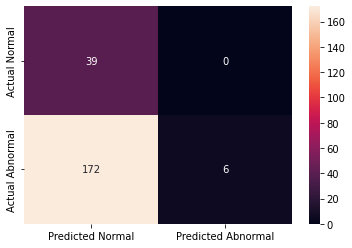

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Abnormal"],
columns=["Predicted Normal", "Predicted Abnormal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [22]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['Normal','Abnormal']))

              precision    recall  f1-score   support

      Normal       0.18      1.00      0.31        39
    Abnormal       1.00      0.03      0.07       178

    accuracy                           0.21       217
   macro avg       0.59      0.52      0.19       217
weighted avg       0.85      0.21      0.11       217



Here we can see with our first tweaked model that accuracy has not improved  but instead has dropped! It has gone from 41% to a little under 18%! This unfortunately is part of the modeling process; sometimes changing the initial model can cause it to do worse over all. We've included a confusion matrix to look a little more in depth as to our problematic model.

From the confusion matrix we can see that the model is having some issues on the abnormal side of our dataset. It has accurately deduced what is normal, but largely mislabels the abnormal images. This can be seen as a type 2 error with our dataset, meaning it could be a result of our small sample sizing. It would appear that there is some room for further improvement from this model and one solution would be to increase the sample size so that there is more information to draw on. Due to the uncommon nature of otoscopies however, this is not possible at this time but let's continue on for now. 

(217, 500, 500, 1)
(217,)


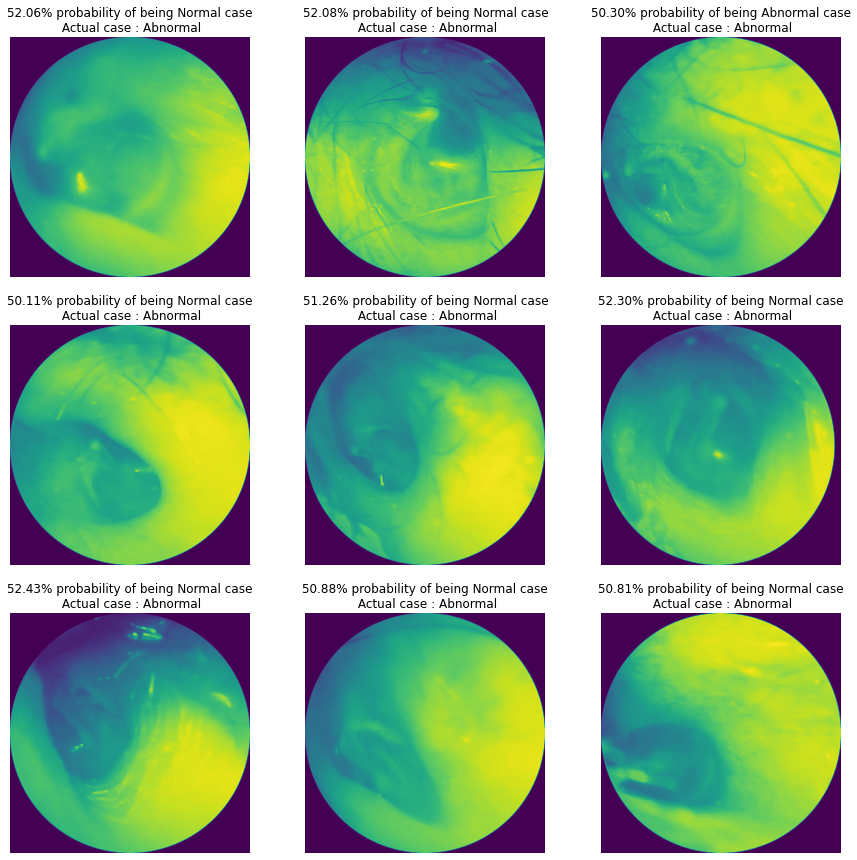

In [23]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)


#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 


dic = {0:'Normal', 1:'Abnormal'}
plt.figure(figsize=(15,15))
for i in range(0+205, 9+205):
  plt.subplot(3, 3, (i-205)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Abnormal case'.format(preds[i][0]))
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

      

We have already come to the conclusion that the typical convolutional neural network model may not be the best fit for what we are trying to achieve. But before we move on, we fel it would be nice to see another visual as to why that type of model isn't our best choice.

With the graph above, we can see the probability of actual images from our dataset that our model predicted the diagnosis of. The images have been randomly selected in addition to changing the color to help identify the difference between normal and abnormal. Once again, this shows that both a generic and fine tuned CNN model isn't the best fit for us. Next step is to try another kind of model that may work out better.

#Second Model

Next model we will try is the VGG16 type convolutional neural network. This differs from the ones above by how this model has a different focus. The VGG is specifically made and pretrained for classification and localization, using a large network of images preloaded into it to help identify imagery. With this in mind, this model may be better suited to our needs. However, it should be kept in mind that while VGG is a trained model on a variety of images, the images from our dataset are not common images like those of cats and dogs. Therefore, this may do better than previous models but do to the nature of our data, it may still have a hard time interpreting and predicting for us.

In [25]:
#installing necessary steps
!pip install tf-explain

In [26]:
#making sure the right libraries are once again imported
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import os

In [27]:
#resizing all the images to a size VGG16 expects
IMAGE_SIZE = [224, 224]

#setting the batch size
BATCH_SIZE = 32  # try reducing batch size and/or freeze more layers if GPU runs out of memory
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 # We are aware of class size but just making sure

In [28]:
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

In [29]:
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['Normal', 'Abnormal'] 
 and the length is : 2


In [30]:
#Image Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

#importing the images from the train dataset
#making sure to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode = 'categorical')

Found 217 images belonging to 2 classes.


In [31]:
test_datagen = ImageDataGenerator(rescale = 1./255)

#importing the images from the test dataset
test_set = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode = 'categorical')

Found 217 images belonging to 2 classes.


In [32]:
#importing the VGG16 library as shown below and adding preprocessing layer to the front of VGG
#using imagenet weights

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [33]:
#don't train existing weights; causes errors otherwise
for layer in vgg.layers:
    layer.trainable = False

In [34]:
x = Flatten()(vgg.output)

prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [35]:
#creating a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
#telling the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
#fitting the model
history = model.fit(training_set, validation_data=test_set, epochs=5, steps_per_epoch=len(training_set), validation_steps=len(test_set))

Epoch 1/5
7/7 [==============================] - 245s 35s/step - loss: 1.5633 - accuracy: 0.7143 - val_loss: 0.5347 - val_accuracy: 0.8203
Epoch 2/5
7/7 [==============================] - 221s 34s/step - loss: 0.8155 - accuracy: 0.6682 - val_loss: 0.8759 - val_accuracy: 0.8203
Epoch 3/5
7/7 [==============================] - 235s 36s/step - loss: 0.7513 - accuracy: 0.6636 - val_loss: 0.5886 - val_accuracy: 0.6544
Epoch 4/5
7/7 [==============================] - 223s 34s/step - loss: 0.7893 - accuracy: 0.8249 - val_loss: 0.5678 - val_accuracy: 0.8203
Epoch 5/5
7/7 [==============================] - 222s 34s/step - loss: 0.5141 - accuracy: 0.7650 - val_loss: 0.5212 - val_accuracy: 0.8203


In [39]:
#generating validation set
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Data/validation', target_size = (224, 224), batch_size = BATCH_SIZE, class_mode = 'categorical')

Found 220 images belonging to 2 classes.


In [40]:
validation_steps = 5

loss0,accuracy0 = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

5/5 [==============================] - 81s 16s/step - loss: 0.5065 - accuracy: 0.8375
loss: 0.51
accuracy: 0.84


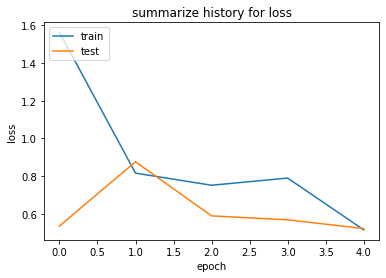

In [41]:
#summarizing the history for loss

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation (Test) loss')
plt.title('summarize history for loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

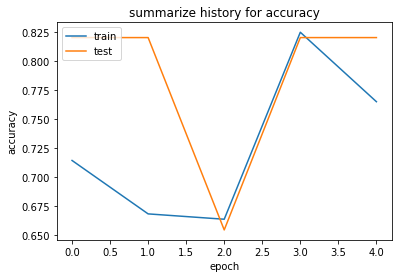

In [42]:
#summarizing the history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('summarize history for accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From implementing the model, we can see that the VGG16 is the one to use for our dataset! Here we've created a VGG model with some modifications to do much better than the previous two. We've used data augmentation to increase the amount of data since we did not have much to help reduce the risk of overfitting, in addition to only running 5 epochs. We've also optimized using the parameter "adam" since it is known for running well with sparse data and requires little memory. This has increased our accuracy to over 80 percent! But we'll also test this by making our model predict and seeing what the outcome is.

In [73]:
# getting sample images to test at random
img_normal = image.load_img('/content/drive/MyDrive/Data/test/Normal/normal (117).png', target_size = (224, 224))
img_abnormal = image.load_img('/content/drive/MyDrive/Data/test/Abnormal/aom (39).png', target_size = (224, 224))

In [74]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model.predict(x_processed)
    if(result[0][0]<.50):
        result="normal"
    else:
        result="abnormal"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))
    
#     return result

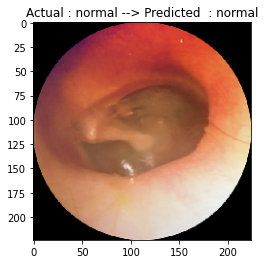

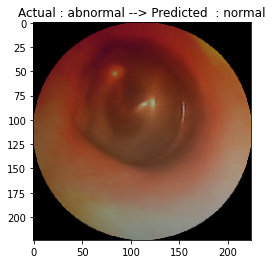

In [75]:
pred_normal = model_predict(img_normal, "normal")
pred_abnormal = model_predict(img_abnormal, "abnormal")

It seems that our model isn't fairing too badly, with out of the images above and what they were predicted to be, one out of two is correct. Modeling with this dataset can be tricky, but over all this VGG16 shows promise and therefore is our chosen process of prediction. We'll talk about everything a little more futher below but before we get to the end results and our conclusions, there is one more process we would like to include.

#LIME
Though we have gone through mulitple iterations of models for our dataset and have come to a conclusion on which one would work for us, there is another process that we will use. If you haven't guessed from the title of this section, it is called LIME or otherwise known as "Local Interpretable Model-agnostic Explanations" and it helps explain how the input features of a model influences it's predictions. We will use it to see if LIME can accurately predict what our images actually contain, although it should be noted that since otoscopies are not usually common, it will most likely not be able to predict accurately. Still, it is something we can revisit in the future when both our dataset and the imagery that LIME trains itself on has grown, but for now we'll settle for what we have.

In [47]:
#inputting lime and necessary tools for it
!pip install lime

In [48]:
inet_model = inc_net.InceptionV3()

In [49]:
#defining a function to simplify LIME processing paths
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

('n01910747', 'jellyfish', 0.28587818)
('n09229709', 'bubble', 0.2374768)
('n04286575', 'spotlight', 0.1451265)
('n01968897', 'chambered_nautilus', 0.045194358)
('n02782093', 'balloon', 0.015901642)


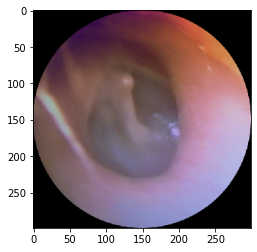

In [50]:
images = transform_img_fn([os.path.join('/content/drive/MyDrive/Data/test/Abnormal/aom (1).png','/content/drive/MyDrive/Data/test/Normal/normal (1).png')])
#dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [58]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from skimage.segmentation import mark_boundaries

In [60]:
%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


  0%|          | 0/1000 [00:00<?, ?it/s]

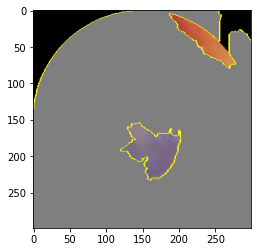

In [61]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

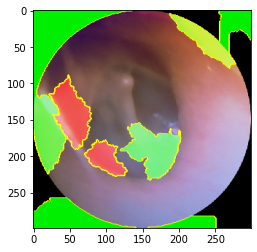

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

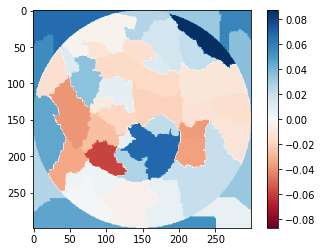

In [63]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

As stated above, LIME wasn't able to accurately identify what our images contained and this wasn't too much of a surprise. Still, it was fascinating to see that the highest predictions included jelly fish and bubble. It is also intriguing to see how in the explanations from LIME about our images, it shows exactly where and how it came to those outcomes. LIME is an informative tool for image classification for most instances, but unfortunately for us it was not too much help.

#Conclusion
After trying out a few different models with our dataset, we can comfortably come to the conclusion that the best suited is our VGG16 model. It had high accuracy, took less time to run and had decent prediction power. Nonetheless, as expressed earlier, our dataset is smaller and less common than most image datasets. Hopefully in the future more otoscopies can become readily available as well as have more models trained on this information so that following models will have more success in their predictions. 